## 过滤式特征选取

主要原理是通过数据的发散性或者相关性对各个特征进行评分，设定阈值或者待选取的阈值个数来选取特征。

### 方差过滤

In [1]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif


def test_VarianceThreshold():
    X = [[100, 1, 2, 3], 
         [100, 4, 5, 6], 
         [100, 7, 8, 9], 
         [101, 11, 12, 13]]
    selector = VarianceThreshold(1)   # 阈值设置为1
    selector.fit(X)
    print("Variances is %s" % selector.variances_)
    print("After transform is %s" % selector.transform(X))
    print("The surport is %s" % selector.get_support(True))
    print(
        "After reverse transform is %s"
        % selector.inverse_transform(selector.transform(X))     # 将被选取出来的特征还原成原始数据，缺失值使用0填充
    )


test_VarianceThreshold()

Variances is [ 0.1875 13.6875 13.6875 13.6875]
After transform is [[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [11 12 13]]
The surport is [1 2 3]
After reverse transform is [[ 0  1  2  3]
 [ 0  4  5  6]
 [ 0  7  8  9]
 [ 0 11 12 13]]


### 单变量过滤

这是一个有监督学习，需要标签向量y

`SelectKBest` 使用 `f_classif`（方差分析 ANOVA）作为得分函数。ANOVA 是用于检验不同组别（如类别 0 和 1）之间各个特征的均值是否显著不同的统计方法

补充：
$$
F = \frac{\text{组间方差}}{\text{组内方差}}
$$
F值越大，说明类别之间的方差大于类别内部的方差，表明该特征对区分目标变量（如 `y` 中的类别 `0` 和 `1`）是有帮助的。

反之，F值较小，说明不同类别之间在该特征上没有显著差异，该特征对分类帮助不大。

**p** 值是基于 F 检验结果得出的显著性水平，用来评估**是否应该拒绝原假设**（**该特征与目标变量无关**）。它表示在原假设成立的情况下，**观察到等于或更极端的检验统计量（F值）的概率**

In [2]:
def test_SelectKBest():
    X = [[1, 2, 3, 4, 5],
         [5, 4, 3, 2, 1],
         [3, 3, 3, 3, 3],
         [1, 1, 1, 1, 1]]
    y = [0, 1, 0, 1]
    print("before transform:", X)
    selector = SelectKBest(score_func=f_classif, k=3) # 保留3个最好的特征，使用f_classif方差分析作为得分函数
    selector.fit(X, y)      
    print("scores_:", selector.scores_)     # 每个特征的 F值
    print("pvalues_:", selector.pvalues_)   # 每个特征的 p值
    print("selected index:", selector.get_support(True))
    print("after transform:", selector.transform(X))


test_SelectKBest()

before transform: [[1, 2, 3, 4, 5], [5, 4, 3, 2, 1], [3, 3, 3, 3, 3], [1, 1, 1, 1, 1]]
scores_: [0.2 0.  1.  8.  9. ]
pvalues_: [0.69848866 1.         0.42264973 0.10557281 0.09546597]
selected index: [2 3 4]
after transform: [[3 4 5]
 [3 2 1]
 [3 3 3]
 [1 1 1]]


总结：
- **F值高，p值低**：说明这个特征对目标变量的区分能力强，类别间差异显著。
- **F值低，p值高**：表示这个特征对目标变量的区分能力弱，不显著。

## 包裹式特征选取

### RFE递归特征删除

本质上是将特征选择看作一个特征子集搜索问题，筛选各种特征子集，再用模型评估效果

In [3]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


def test_RFE():
    iris = load_iris()
    X = iris.data
    y = iris.target
    estimator = LinearSVC()
    selector = RFE(estimator=estimator, n_features_to_select=2)
    selector.fit(X, y)
    print("N_features %s" % selector.n_features_)
    print("Support is %s" % selector.support_)
    print("Ranking %s" % selector.ranking_)


def test_compare_with_no_feature_selection():
    ### 加载数据
    iris = load_iris()
    X, y = iris.data, iris.target
    ### 特征提取
    estimator = LinearSVC()
    selector = RFE(estimator=estimator, n_features_to_select=2)
    X_t = selector.fit_transform(X, y)
    #### 切分测试集与验证集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=0, stratify=y
    )
    X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
        X_t, y, test_size=0.25, random_state=0, stratify=y
    )
    ### 测试与验证
    clf = LinearSVC()
    clf_t = LinearSVC()
    clf.fit(X_train, y_train)
    clf_t.fit(X_train_t, y_train_t)
    print("Original DataSet: test score=%s" % (clf.score(X_test, y_test)))
    print("Selected DataSet: test score=%s" % (clf_t.score(X_test_t, y_test_t)))


test_RFE()  # 调用 test_RFE
test_compare_with_no_feature_selection()  # 调用 test_compare_with_no_feature_selection

N_features 2
Support is [False  True False  True]
Ranking [3 1 2 1]
Original DataSet: test score=0.9473684210526315
Selected DataSet: test score=0.9473684210526315


### 嵌入式特征选取

还不是很懂(

d:\Code\Github\AI_Learn\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Threshold: 0.6789522646876391
Selected features: [ 2  3  4  5  6  9 12 13 14 18 19 20 21 22 25 26 27 30 33 36 38 41 42 43
 44 45 51 53 54 55 58 61]
Transformed shape: (1797, 32)


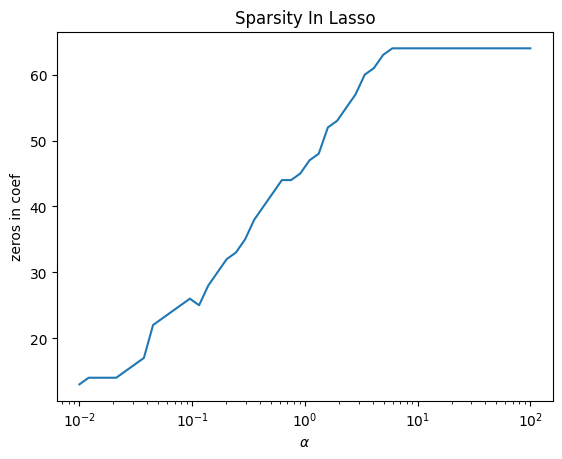

d:\Code\Github\AI_Learn\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Github\AI_Learn\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Github\AI_Learn\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Github\AI_Learn\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Github\AI_Learn\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
d:\Code\Github\AI_Learn\.venv\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to 

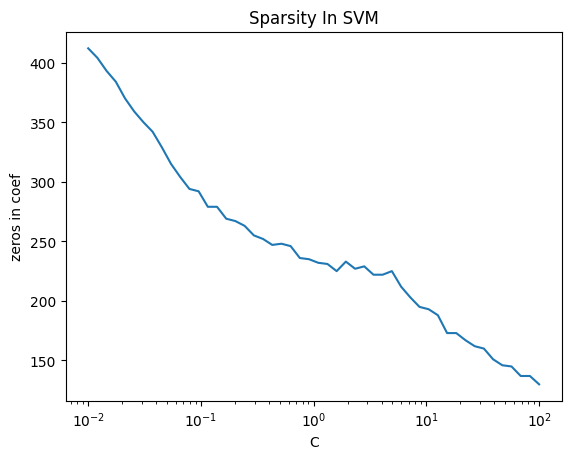

In [4]:
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# 加载数据
digits = load_digits()
X = digits.data
y = digits.target

def calculate_zeros(coef_matrix, threshold=1e-5):
    """计算系数矩阵中接近零的元素数量"""
    return np.sum(np.abs(coef_matrix) < threshold)

def plot_sparsity(param_values, zeros, param_name, title):
    """绘制稀疏性变化图"""
    fig, ax = plt.subplots()
    ax.plot(param_values, zeros)
    ax.set_xlabel(param_name)
    ax.set_xscale("log")
    ax.set_ylabel("zeros in coef")
    ax.set_title(title)
    plt.show()

def test_SelectFromModel():
    estimator = LinearSVC(penalty="l1", dual=False)
    selector = SelectFromModel(estimator=estimator, threshold="mean")
    selector.fit(X, y)
    X_transformed = selector.transform(X)
    print("Threshold:", selector.threshold_)
    print("Selected features:", selector.get_support(indices=True))
    print("Transformed shape:", X_transformed.shape)

def test_Lasso():
    alphas = np.logspace(-2, 2)
    zeros = []
    for alpha in alphas:
        regr = Lasso(alpha=alpha)
        regr.fit(X, y)
        zeros.append(calculate_zeros(regr.coef_))  # 使用 calculate_zeros
    plot_sparsity(alphas, zeros, r"$\alpha$", "Sparsity In Lasso")

def test_LinearSVC():
    Cs = np.logspace(-2, 2)
    zeros = []
    for C in Cs:
        clf = LinearSVC(C=C, penalty="l1", dual=False, max_iter=10000)
        clf.fit(X, y)
        zeros.append(calculate_zeros(clf.coef_))  # 使用 calculate_zeros
    plot_sparsity(Cs, zeros, "C", "Sparsity In SVM")

# 调用测试函数
test_SelectFromModel()  # 调用 test_SelectFromModel
test_Lasso()  # 调用 test_Lasso
test_LinearSVC()  # 调用 test_LinearSVC